In [1]:
%reload_ext autoreload
%autoreload 2
import os
import re

from dill import dump_session, load_session

import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display
from ipywidgets import widgets, interactive

from scipy.io import mmread

from typing import List

In [36]:
dump_session('notebook_env.db')

In [6]:
load_session('notebook_env.db')

In [4]:
# @title Download data if not exist (takes a while)
from util import download_all_data_if_not_exist, unzip

download_all_data_if_not_exist('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE156nnn/GSE156455/suppl', './datasets/gziped',filter=lambda file: file.endswith('.gz'))
unzip('./datasets/gziped/', './datasets')

File already exists: GSE156455_barcodes_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_barcodes_main.tsv.gz in ./datasets/gziped
File already exists: GSE156455_features_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_features_main.tsv.gz in ./datasets/gziped
File already exists: GSE156455_matrix_early.mtx.gz in ./datasets/gziped
File already exists: GSE156455_matrix_main.mtx.gz in ./datasets/gziped
File already exists: GSE156455_metadata_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_metadata_main.tsv.gz in ./datasets/gziped
File already exists: GSE156455_tsne_early.tsv.gz in ./datasets/gziped
File already exists: GSE156455_tsne_main.tsv.gz in ./datasets/gziped


In [5]:
# @title Load data (takes a while)
data_dir = "./datasets"
data_type = "main"

def show_widget_datatype_select():
  dropdown = widgets.Dropdown(options=["early", "main"], value="main", description="dataset:")

  def on_value_change(t: str):
    global data_type 
    data_type = t

  interactive(on_value_change, t=dropdown)
  display(dropdown)

show_widget_datatype_select()

Dropdown(description='dataset:', index=1, options=('early', 'main'), value='main')

In [6]:
path = lambda filename: os.path.join(data_dir, filename)

matrix_src = path(f"GSE156455_matrix_{data_type}.mtx")
feature_src = path(f"GSE156455_features_{data_type}.tsv")
barcode_src = path(f"GSE156455_barcodes_{data_type}.tsv")
metadata_src = path(f"GSE156455_metadata_{data_type}.tsv")
tsne_src = path(f"GSE156455_tsne_{data_type}.tsv")

# read in MEX format matrix as table
mat = mmread(matrix_src)

# feature_id:   transcript ids, e.g. 'FBgn0038498'
# feature_name: gene names,     e.g. 'beat-IIa'
# feature_type: feature types,  e.g. 'Gene Expression'
feature_df = pd.read_table(feature_src, names=['feature_id', 'feature_name', 'feature_type'])

# barcode:      cell ids        e.g. 'DGRP_All_A_2_TGATTTCGTCATCCGG'
barcode_df = pd.read_table(barcode_src, names=['barcode'])

# barcode:      cellID
# set:          W1118 or DGRP datasets
# rep:          biological replicate (A/B)
# trep:         technical replicate (i.e. a single 10X library, see sampleID format below)
# genotype:     W1118 or DGRP strain (based on demultiplexing)
# time:         timepoint
# class:        cell class
# type:         cell type or cluster identity
# subtype:      cell subtype (if not applicable, same as type)
metadata_df = pd.read_table(metadata_src)

# barcode:      cellID
# tsne_1:       tSNE 1
# tsne_2:       tSNE 2
tsne_df = pd.read_table(tsne_src)

matrix = pd.DataFrame.sparse.from_spmatrix(mat, columns=barcode_df.barcode)
data = pd.concat([feature_df, matrix], axis=1)
data.set_index("feature_id", inplace=True)
data.head()

,feature_name,feature_type,DGRP_All_A_3_GCGGAAAGTGGTCTCG,DGRP_All_A_4_TCCATGCCATCGGTTA,DGRP_All_A_5_TTGAACGAGGAGTATT,DGRP_All_A_8_TCACACCGTTGCATTG,DGRP_All_A_2_ACTATGGGTTCAGTAC,DGRP_All_A_8_GAACACTTCGTCCATC,DGRP_All_A_3_TCGACGGTCAGGAAAT,DGRP_All_A_8_GCAACCGTCAATCTCT,...,W1118_Adult_A_2_CGCAGGTAGCACTAGG,W1118_Adult_A_1_TAACGACTCGTGTCAA,W1118_Adult_A_1_GGCACGTGTGAGCCAA,W1118_Adult_A_3_GCAACCGTCAAACGAA,W1118_Adult_A_1_AGGGTCCGTATTAAGG,W1118_Adult_A_1_ACGTTCCCAATAGTGA,W1118_Adult_A_1_GTAGGAGAGCGAGAAA,W1118_Adult_A_2_GTCCTCATCATGCCCT,W1118_Adult_A_4_CAAAGAAAGAGCCGTA,W1118_Adult_A_3_TCGGGTGAGAGCCATG
feature_id,,,,,,,,,,,,,,,,,,,,,
FBgn0031081,Nep3,Gene Expression,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
FBgn0052826,tRNA:Pro-CGG-1-1,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031085,CG9570,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0062565,Or19b,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FBgn0031088,CG15322,Gene Expression,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
feature_by_cell = data.drop(['feature_name', 'feature_type'], axis=1)
cell_by_feature = feature_by_cell.T

In [8]:
feature_by_cell = np.log(feature_by_cell + 1)
cell_by_feature = np.log(cell_by_feature + 1)

In [9]:
tsne_with_metadata = pd.merge(tsne_df, metadata_df, on='barcode')

types = tsne_with_metadata['type'].unique()

centers = tsne_with_metadata.groupby('type').mean()[['tSNE_1', 'tSNE_2']]

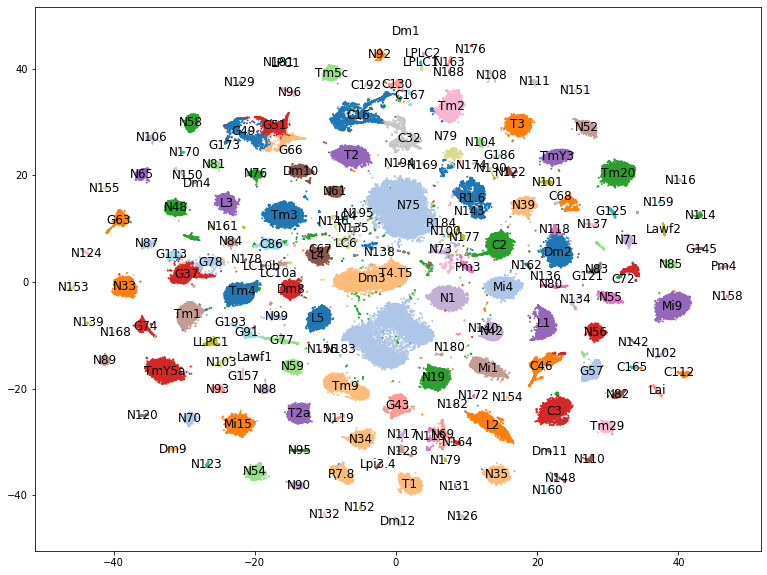

In [10]:
# @title Plot tSNE
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)

cmap = cm.get_cmap('tab20', len(types))
cdict = {t: cmap(i) for i, t in enumerate(types)}
c = [cdict[t] for t in tsne_with_metadata['type']]

ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c=c)
for t, (tsne1, tsne2) in centers.iterrows():
    ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12)

In [11]:
# feature_ids: List[str] = ["FBgn0038498"]
# time: List[str] = ["12h"]

# fig = plt.figure(figsize=(13, 10))
# ax = fig.add_subplot(111)

# expressions = cell_by_feature[feature_ids]
# for col in expressions.columns:
#     # workaround
#     expressions[col] = np.log2(1 + expressions[col] / expressions[col].max())

# # base plot
# ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c='gray', alpha=0.3)
# for t, (tsne1, tsne2) in centers.iterrows():
#     ax.annotate(str(t), (tsne2, tsne1), ha='center', va='center', fontsize=12)

# tsne_with_metadata_and_expression = pd.merge(tsne_with_metadata, expressions, left_on='barcode', right_index=True)

# filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression[feature_ids[0]] > 0]
# filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression['time'].isin(time)]
# ax.scatter(filtered['tSNE_2'], filtered['tSNE_1'], s=1, c='red', alpha=tsne_with_metadata_and_expression[feature_ids[0]])

In [12]:
## WIP
# def show_widget_filtered_plot():
#     multiple1 = widgets.SelectMultiple(options=feature_df["feature_id"].unique(), value=["FBgn0038498"], description="gene:")
#     multiple2 = widgets.Dropdown(options=["0h", "12h", "24h"], value="12h", description="time:")

#     def show_plot(feature_ids: List[str], time: List[str]):
#         fig = plt.figure(figsize=(13, 10))
#         ax = fig.add_subplot(111)

#         expressions = cell_by_feature[feature_ids]
#         for col in expressions.columns:
#             # workaround
#             expressions[col] = np.log2(1 + expressions[col] / expressions[col].max())

#         # base plot
#         ax.scatter(tsne_with_metadata['tSNE_2'], tsne_with_metadata['tSNE_1'], s=1, c='gray', alpha=0.3)
#         for t, (tsne1, tsne2) in centers.iterrows():
#             ax.annotate(t, (tsne2, tsne1), ha='center', va='center', fontsize=12) #type:ignore

#         tsne_with_metadata_and_expression = pd.merge(tsne_with_metadata, expressions, left_on='barcode', right_index=True) #type:ignore

#         cmap = cm.get_cmap('tab20', len(feature_ids))
#         for i, feature_id in enumerate(feature_ids):
#             filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression[feature_id] > 0]
#             filtered = tsne_with_metadata_and_expression[tsne_with_metadata_and_expression['time'].isin(time)]
#             ax.scatter(filtered['tSNE_2'], filtered['tSNE_1'], s=1, c=cmap(i), alpha=tsne_with_metadata_and_expression[feature_id])

#     interactive(show_plot, feature_ids=multiple1, time=multiple2)
#     display(multiple1, multiple2);

# show_widget_filtered_plot()

0


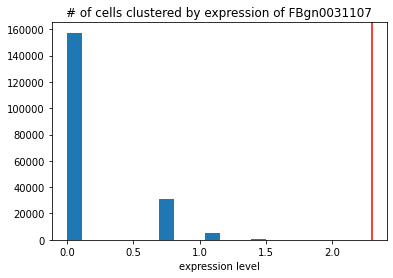

In [24]:
# @title Parameters
threshold_of_expression = 2.3
target_feature_name = "side3"
target_feature_id = "FBgn0031107"

fig = plt.figure()
ax = fig.add_subplot(111)
K = int(1 + np.log2(len(cell_by_feature[target_feature_id])))
ax.hist(cell_by_feature[target_feature_id], bins=K)
ax.set_title("# of cells clustered by expression of {}".format(target_feature_id))
ax.set_xlabel("expression level")
print(len(cell_by_feature[target_feature_id][cell_by_feature[target_feature_id] > threshold_of_expression]))
ax.vlines(threshold_of_expression, 0, 1, colors='red', transform=ax.get_xaxis_transform());

In [8]:
# get all cells which have a feature expression above the threshold
cell_ids = cell_by_feature[target_feature_id][cell_by_feature[target_feature_id] > threshold_of_expression].index

In [9]:
# @title Linear regression
def linear_regression(filtered_cell_ids: List[str], target_feature_id: str):
  filtered = feature_by_cell[filtered_cell_ids]
  X = np.nan_to_num(filtered.drop(target_feature_id, axis=0).T.values)
  y = np.nan_to_num(np.array(filtered.T[target_feature_id].values))

  theta = np.linalg.pinv(X) @ y

  return theta, y.mean()

In [10]:
meta = metadata_df.set_index("barcode")

In [11]:
# filtered_cell_ids = [cell_id for cell_id in cell_ids if re.match("L\d", meta.loc[cell_id]["type"])]
filtered_cell_ids = [cell_id for cell_id in cell_ids if meta.loc[cell_id]["type"] == "R7" or meta.loc[cell_id]["type"] == "R8"]
theta, y_mean = linear_regression(filtered_cell_ids, target_feature_id)

/var/folders/w7/rrcz7y056_q_zqnsld3kmr580000gn/T/ipykernel_24179/3613394985.py:9: RuntimeWarning: Mean of empty slice.
  return theta, y.mean()
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0


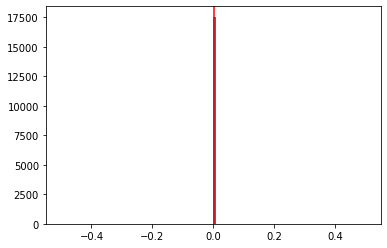

In [12]:
threshold_of_weight = 0.001

print(len(theta[theta > threshold_of_weight]))

fig = plt.figure()
ax = fig.add_subplot(111)
K = 100
ax.hist(theta, bins=K)
ax.vlines(threshold_of_weight, 0, 1, colors='r', transform=ax.get_xaxis_transform());

In [13]:
features = feature_by_cell[filtered_cell_ids].drop(target_feature_id, axis=0).index
feature_ids = np.array(features[theta > threshold_of_weight]) #type: ignore
len(feature_ids)

0

In [14]:
for_join = pd.DataFrame({"feature_id": features, "theta": theta})

In [15]:
feature_df_with_theta = feature_df.join(for_join.set_index("feature_id"), on="feature_id")
coexpressed_genes = feature_df_with_theta[feature_df_with_theta['feature_id'].isin(feature_ids)].sort_values(by='theta', ascending=False).head(50)
coexpressed_genes.to_csv(f"{target_feature_name}.csv")
coexpressed_genes

,feature_id,feature_name,feature_type,theta


In [16]:
coexpressed_genes_dict = dict(zip(coexpressed_genes["feature_id"], coexpressed_genes["feature_name"]))
coexpressed_genes_dict 

{}

In [22]:
# sides = {"FBgn0016061": "side", "FBgn0259213": "side-II", "FBgn0083949": "side-III", "FBgn0038156": "side-IV", "FBgn0085400": "side-V", "FBgn0083950": "side-VI", "FBgn0037736": "side-VII", "FBgn0086604": "side-III", "FBgn0031107": "HERC2"}
sides = {"FBgn0031107": "HERC2"}
irm = {"FBgn0028369": "kirre", "FBgn0024189": "sns", "FBgn0029082": "hbs", "FBgn0003285": "rst"}

times = ["24h", "36h", "48h", "60h", "72h", "84h", "96h"]

In [20]:
cell_by_feature_with_metadata = pd.merge(cell_by_feature, metadata_df, left_index=True, right_on="barcode") #type:ignore

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by the normalize function.

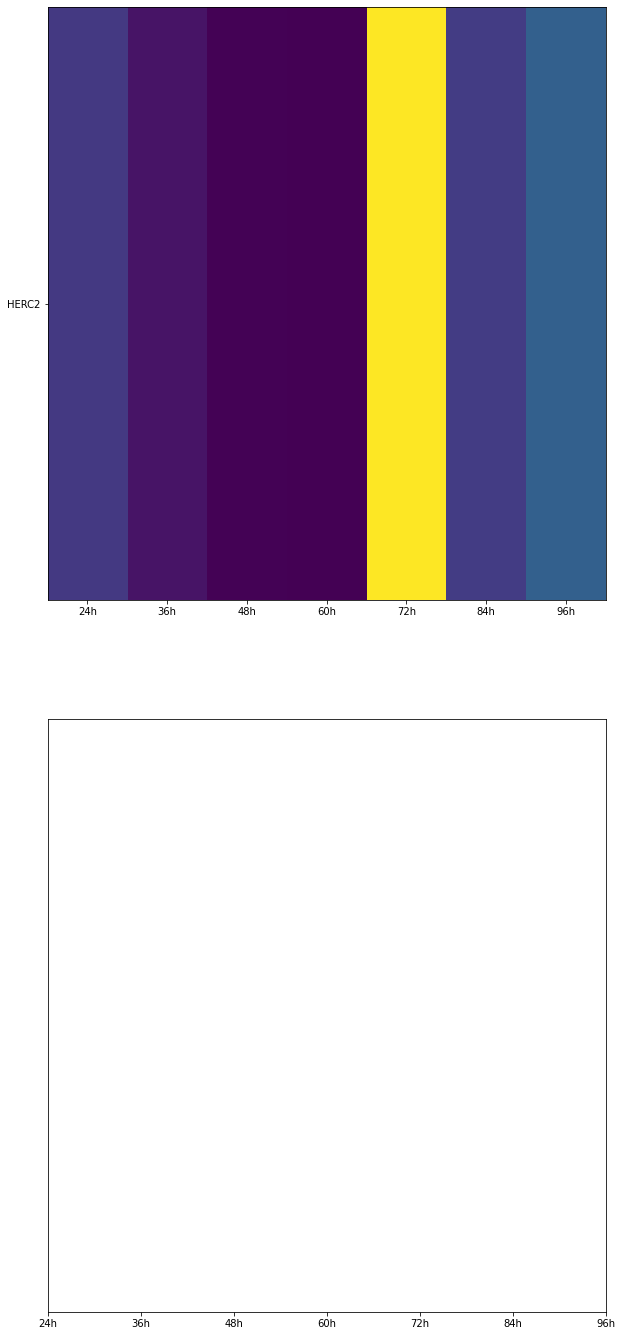

In [23]:
from sklearn.preprocessing import normalize

# gene_ids = list(sides.keys())+list(irm.keys())
# gene_names = list(sides.values())+list(irm.values())

gene_ids = list(sides.keys())
gene_names = list(sides.values())

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(10, 24))

ax1.set_xticks(np.arange(len(times)), labels=times)
ax1.set_yticks(np.arange(len(gene_ids)), labels=gene_names)

expressions = np.zeros((len(gene_ids), len(times)))

for i, id in enumerate(gene_ids):
  for j, time in enumerate(times):
    expressions[i, j] = cell_by_feature_with_metadata[id][cell_by_feature_with_metadata["time"] == time].mean()

ax1.imshow(expressions, aspect="auto")

gene_ids = list(coexpressed_genes_dict.keys())
gene_names = list(coexpressed_genes_dict.values())

ax2.set_xticks(np.arange(len(times)), labels=times)
ax2.set_yticks(np.arange(len(gene_ids)), labels=gene_names)

expressions = np.zeros((len(gene_ids), len(times)))

for i, id in enumerate(gene_ids):
  for j, time in enumerate(times):
    expressions[i, j] = cell_by_feature_with_metadata[id][cell_by_feature_with_metadata["time"] == time].mean()

expressions = normalize(expressions, axis=1, norm='l1')
ax2.imshow(expressions, aspect="auto")

fig.savefig(f'{target_feature_name}.png', dpi=100)